<img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> University of Haifa - Computer Vision course


## Homework 1 - 2D features and transformations
---

### <a style='color:red'> Due Date: 02.5.2025 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**, unless you have already got an approval to work on your own

* Submission is only through Moodle

* You can choose your working environment:
    * `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
        * Colab also supports running code on GPU, but you will not need it for this excercise.
    * Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both allow editing and running Jupyter Notebooks.
<div style="margin-top:6px;"></div>

* You should submit only this ipynb notebook file, **with all cells executed such that the results will be included**.
<div style="margin-top:6px;"></div>

* Read the instructions carefully:
    * You have functions to complete and scripts to write - look for <span style="color:red">''' YOUR CODE HERE '''</span>
        * Make sure to properly document your code
        * Notice where you can use existing implementations (e.g. opencv) freely and in which cases you have to provide your own implementation of certain steps
    * You have some explanations and discussions to write - look for <span style="color: red; font-weight: bold;">YOUR DISCUSSION HERE</span>
        * Make sure to answer shortly but informatively
<div style="margin-top:6px;"></div>

* Code of Honor:
    * We wish to avoid dealing with copied homework. However, we will not hesitate to take serious actions against students that are caught with violations of the Honor Code. Note that in this course, it is rather easy to detect similar submissions, as most of them require your "personal" touch.     
<div style="margin-top:6px;"></div>

* Submission date:
    * Submission date of 02.5.2025 is final and will not be delayed
    * However, you may submit up to 2 days late (till Sunday 04.5.2025) at the cost of 4 points per day
    * Any (fully justified and documented) requests for delay must be sent till Monday 28.4 at the latest
    * The excercise is long and isn't easy - **make sure to start early**


### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `opencv` (or `scikit-image`)
* `scikit-learn`
* `scipy`
* Anything else you need (`os`, `pandas`, `csv`, `json`,...)

## Introduction 
---
In this excercise:
* We will implement an interest point (keypoint) detector similar to SIFT.
* Then, we will implement BRIEF, which is another commonly used feature descriptor. The BRIEF is more compact and quicker than SIFT, allowing real-time computation. We will observe that it is not invariant to rotation and therefore implement ORB, a variant that solves this problem.
* Finally, we will implement panorama stitching, based on SIFT matching and homography estimation, with\out RANSAC.

# Part 1 - A Keypoint Detector
---
The first part will include implementing an interest point detector, similar to SIFT. Additional details for the chosen implementation can be found in <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>. 
In order to find keypoints, we will use the Difference of Gaussian (DoG) detector <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1095851">[1]</a>. We will use a simplified version of (DoG) as described in section 3 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>. 

NOTE: The parameters to use for the following sections are:

* $\sigma_0 = 1$, $k =\sqrt 2$, $levels = [0; 1; 2; 3; 4; 5]$



### 1.1 Load Image
Load the `model_can.jpg` image and show it:

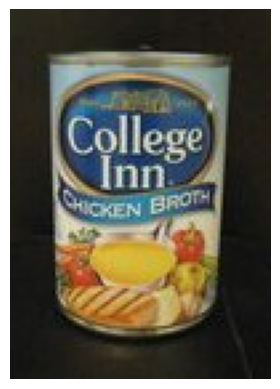

In [70]:
# imports for hw1 (you can add any other library as well)
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

im = cv2.imread('data/model_can.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')
plt.show()

### 1.2 Gaussian Pyramid
Before we construct a DoG pyramid, we need to construct a Gaussian Pyramid by progressively applying a low pass Gaussian filter to the input image.
We provide you the following function `createGaussianPyramid` which gets a grayscale image with values between 0 to 1 (hint: normalize your input image and convert to grayscale). This function outputs GaussianPyramid matrix, which is a set of $L=len(levels)$ blurred images.

What is the shape of GaussianPyramid matrix?

In [71]:
def createGaussianPyramid(im, sigma0, k, levels):
    GaussianPyramid = []
    for i in range(len(levels)):
        sigma_ = sigma0 * k ** levels[i]
        size = int(np.floor( 3 * sigma_ * 2) + 1)
        blur = cv2.GaussianBlur(im,(size,size),sigma_)
        GaussianPyramid.append(blur)
    return np.stack(GaussianPyramid)

* Use the following function to visualize your pyramid on the model_can image

In [72]:
def displayPyramid(pyramid):
    plt.figure(figsize=(16,5))
    plt.imshow(np.hstack(pyramid), cmap='gray')
    plt.axis('off')
    plt.show()

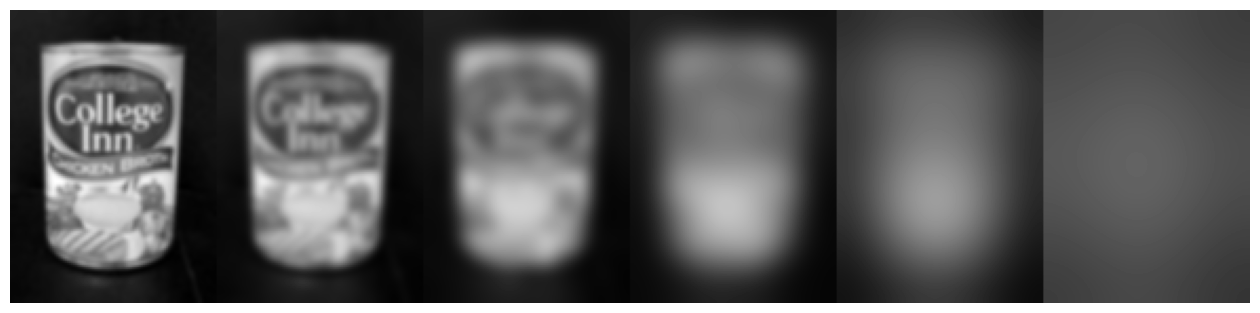

Shape of GaussianPyramid matrix: (6, 139, 98)


In [73]:
# Load the image and convert it to grayscale
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255.0

# Define parameters for the Gaussian Pyramid
sigma0 = 1
k = 2
levels = [0, 1, 2, 3, 4, 5]

# Create the Gaussian Pyramid
GaussianPyramid = createGaussianPyramid(im_gray, sigma0, k, levels)

# Visualize the Gaussian Pyramid
displayPyramid(GaussianPyramid)

# Print the shape of the Gaussian Pyramid matrix
print("Shape of GaussianPyramid matrix:", GaussianPyramid.shape)

### 1.3 The DoG Pyramid
In this section we will construct the DoG pyramid. Each level of the DoG is constructed by substructing two levels of the Gaussian pyramid:

$$D_l(x,y,\sigma_l) = (G(x,y,\sigma_{l-1})-G(x,y,\sigma_l))*I(x,y)$$

Where $G(x,y,\sigma_l)$ is the Gaussian filter used at level $l$ in the Gaussian pyramid, $I(x,y)$ is the original image, and $*$ is the *convolution* operator.

We can simplify the equation due to the distributive property of convolution:

$$D_l(x,y,\sigma_l) = G(x,y,\sigma_{l-1})*I(x,y)-G(x,y,\sigma_l)*I(x,y)=GP_{l-1}-GP_{l}$$

Where $GP_l$ is the level $l$ in the Gaussian pyramid.

<img src="./assets/Gaussian_DoG_pyramid.PNG" width="400">

* Write the following function to constract a DoG pyramid:

In [74]:
def createDoGPyramid(GaussianPyramid, levels):
    # Produces DoG Pyramid
    # inputs
    # GaussianPyramid - A matrix of grayscale images of size
    #                    (len(levels), shape(im))
    # levels          - the levels of the pyramid where the blur at each level is
    #                   outputs
    # DoGPyramid      - size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    #                   created by differencing the Gaussian Pyramid input
    # DogLevels       - the levels of the pyramid where the blur at each level corresponds
    #                   to the DoG scale

    DoGPyramid = []
    for i in range(1, len(levels)):
        DoG = GaussianPyramid[i] - GaussianPyramid[i - 1]
        DoGPyramid.append(DoG)

    DoGPyramid = np.stack(DoGPyramid)
    DoGLevels = levels[1:]

    return DoGPyramid, DoGLevels

This function should return DoGPyramid an $(L-1)\times imH \times imW$ matrix, where $imH\times imW$ is the original image resolution.

### 1.4 Edge Suppression
The Difference of Gaussian function responds strongly on corners and edges in addition to blob-like objects. However, edges are not desirable for feature extraction as they are not as distinctive and do not provide a substantially stable localization for keypoints.

Here, we will implement the edge removal method described in Section 4.1 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>, which is based on the principal curvature ratio in a local neighborhood of a point. The paper presents the observation that edge points will have a "large principal curvature across
the edge but a small one in the perpendicular direction."


* Implement the following function:

In [75]:
def computePrincipalCurvature(DoGPyramid):
    # Edge Suppression
    #  Takes in DoGPyramid generated in createDoGPyramid and returns
    #  PrincipalCurvature,a matrix of the same size where each point contains the
    #  curvature ratio R for the corre-sponding point in the DoG pyramid
    # 
    #  INPUTS
    #  DoG Pyramid - size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    # 
    #  OUTPUTS
    #  PrincipalCurvature - size (len(levels) - 1, shape(im)) matrix where each 
    #                       point contains the curvature ratio R for the 
    #                       corresponding point in the DoG pyramid

    PrincipalCurvature = np.zeros_like(DoGPyramid)
    epsilon = 1e-8  # To avoid division by zero

    for i in range(DoGPyramid.shape[0]):
        # Compute second-order derivatives using Sobel filter
        Dxx = cv2.Sobel(DoGPyramid[i], cv2.CV_64F, 2, 0, ksize=3)
        Dyy = cv2.Sobel(DoGPyramid[i], cv2.CV_64F, 0, 2, ksize=3)
        Dxy = cv2.Sobel(DoGPyramid[i], cv2.CV_64F, 1, 1, ksize=3)

        # Compute trace and determinant of the Hessian matrix
        trace_H = Dxx + Dyy
        det_H = (Dxx * Dyy) - (Dxy ** 2)

        # Compute curvature ratio R
        PrincipalCurvature[i] = (trace_H ** 2) / (det_H + epsilon)

    return PrincipalCurvature

The function takes in DoGPyramid generated in the previous section and returns PrincipalCurvature, a matrix of the same size where each point contains the curvature ratio R for the corresponding point in the DoG pyramid:

$ R = \frac{TR(H)^2}{Det(H)} = \frac{(\lambda_{min}+\lambda_{max})^2}{\lambda_{min}\lambda_{max}}$

where H is the Hessian of the Difference of Gaussian function (i.e. one level of the DoG pyramid) computed by using pixel differences as mentioned in Section 4.1 of [2]. **Use the Sobel filter to  compute the second order derivatives** (hint: `cv2.Sobel()`).

$ H = \begin{bmatrix}
D_{xx} & D_{xy}\\
D_{yx} & D_{yy}
\end{bmatrix}$

This is similar in spirit to but different than the Harris corner detection matrix you saw in class. Both methods examine the eigenvalues $\lambda$ of a matrix, but the method in <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a> performs a test without requiring the direct computation of the eigenvalues. Note that you need to compute each term of the Hessian before being able to take the trace and
determinant. Feel free to implement the mathemtical formulas of $TR(H)$ and $Det(H)$ directly without explicitly building $H$. In addition, to avoid division by zero, please add a safeguard $\epsilon=10^{-8}$ to the denominator of $R$.

We can see that $R$ reaches its minimum when the two eigenvalues $\lambda_{min}$ and $\lambda_{max}$ are equal, meaning that the curvature is the same in the two principal directions. Edge points, in general, will have a principal curvature significantly larger in one direction than the other. To remove edge points, we simply check against a threshold $R > \theta_r$. In addition, in the unlikely event of a negative determinant we also discard points for which $R < 0$.
<!-- Fig. 3 shows t
he DoG detector with and without edge suppression. -->

### 1.5 Detecting Extrema
To detect corner-like, scale-invariant interest points, the DoG detector chooses points that are local extrema in both scale and space. Here, we will consider a point’s eight neighbors in space and its two neighbors in scale (one in the scale above and one in the scale below).

<img src="./assets/DoG_neighbors_10.png" width="200">

* Complete the function:

In [ ]:
def getLocalExtrema(DoGPyramid, DoGLevels, PrincipalCurvature, 
                    th_contrast, th_r): 
    # Returns local extrema points in both scale and space using the DoGPyramid
    # INPUTS
    #       DoGPyramid         - size (len(levels) - 1, imH, imW ) matrix of the DoG pyramid
    #       DoGlevels          - The levels of the pyramid where the blur at each level is
    #                            outputs
    #       PrincipalCurvature - size (len(levels) - 1, imH, imW) matrix contains the
    #                            curvature ratio R
    #       th_contrast        - remove any point that is a local extremum but does not have a
    #                            DoG response magnitude above this threshold
    #       th_r               - remove any edge-like points that have too large a principal
    #                            curvature ratio
    # OUTPUTS
    #       locsDoG            - N x 3 matrix where the DoG pyramid achieves a local extrema in both
    #                            scale and space, and also satisfies the two thresholds.
    
    """
    YOUR CODE HERE
    """
    return locsDoG

This function takes as input `DoGPyramid` and `DoGLevels` from Section 1.3 and `PrincipalCurvature` from Section 1.4. It also takes two threshold values, `th_contrast` and `th_r`. The threshold $\theta_c$ should remove any point that is a local extremum but does not have a Difference
of Gaussian (DoG) response magnitude above this threshold (i.e. $|D(x, y, \sigma)| > \theta_c$). The threshold $\theta_r$ should remove any edge-like points that have too large a principal curvature ratio specified by `PrincipalCurvature`.

The function should return `locsDoG`, a $N \times 3$ matrix ($N$ is the number of the detected extrema points) where the DoG pyramid achieves a local extrema in both scale and space, and also satisfies the two thresholds. The first and second column of `locsDoG` should be the $(x, y)$ values of the local extremum and the third column should contain the corresponding level of the DoG pyramid where it was detected (try to eliminate loops in the function so that it runs efficiently).

**NOTE**: In all implementations, we assume the $x$ coordinate corresponds to
columns and $y$ coordinate corresponds to rows. For example, the coordinate
$(10, 20)$ corresponds to the (row 20, column 10) in the image.




##### 1.6 Putting it Together
* Write the following function to combine the above parts into a DoG detector:

In [ ]:
def DoGdetector(im, sigma0, k, levels, th_contrast=0.03, th_r=12):
    #     Putting it all together
    #     Inputs          Description
    #     --------------------------------------------------------------------------
    #     im              Grayscale image with range [0,1].
    #     sigma0          Scale of the 0th image pyramid.
    #     k               Pyramid Factor.  Suggest sqrt(2).
    #     levels          Levels of pyramid to construct. Suggest -1:4.
    #     th_contrast     DoG contrast threshold.  Suggest 0.03.
    #     th_r            Principal Ratio threshold.  Suggest 12.
    #     Outputs         Description
    #     --------------------------------------------------------------------------
    #     locsDoG         N x 3 matrix where the DoG pyramid achieves a local extrema
    #                     in both scale and space, and satisfies the two thresholds.
    #     gauss_pyramid   A matrix of grayscale images of size (len(levels),imH,imW)
    """
    YOUR CODE HERE
    """    
    return locsDoG, GaussianPyramid

The function should take in a grayscale image, `im`, scaled between 0 and 1, and the parameters `sigma0, k, levels, th_contrast`, and `th_r`. It should use each of the above functions and return the keypoints in `locsDoG` and the Gaussian pyramid in `GaussianPyramid`.
Note that we are dealing with real images here, so your keypoint detector may find points with high scores that you do not perceive to be corners.

### 1.7 Testing
* Run the following functions and script to display detected keypoints over the `sanitycheck.jpg` image.
* Since this image contains only simple geometrical shapes, the detection result should be a perfect detection of all corners as in:

<img src="./assets/sanitycheck_detections2.png" width="400">

In [ ]:
def display_image(frame, title='Image', figsize = (16, 9)):
    """
    Show an image of RGB/Gray levels.
    :param frame: An input grayscale image - ndarray of uint8 type.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1 ,1)
    ax.imshow(frame)
    ax.set_title(title)
    return ax

def plot_image_keypoints(im, locsDoG):
    ax = display_image(im, f'Image with keypoints')
    for keypoint in locsDoG:
        circle = plt.Circle((int(keypoint[0]), int(keypoint[1])), 4, facecolor='r', edgecolor='b',linewidth=0.5)
        ax.add_patch(circle)
    plt.show()

In [ ]:
# script
sanity_im = cv2.imread('../data/sanitycheck.jpg')
sanity_im_gray = cv2.cvtColor(sanity_im, cv2.COLOR_BGR2GRAY)
sanity_im_rgb = cv2.cvtColor(sanity_im, cv2.COLOR_BGR2RGB)
sanity_im_gray = sanity_im_gray / 255

locsDoG, GaussianPyramid = DoGdetector(sanity_im_gray, sigma0, k, levels)
plot_image_keypoints(sanity_im_rgb, locsDoG)

* Apply the dectector and visualize results on the images 'pf_stand.jpg', 'incline_L.png' and on one image of your own.
  * You may tune the input parameters of the DoGdetector function per image.

In [ ]:
"""
YOUR CODE HERE
"""

#  Part 2 - The BRIEF and ORB Descriptors
---
Now that we have interest points that tell us where to find the most informative feature points in the image, we would like to describe each keypoint region with a descriptor. Then we can use those descriptors to match corresponding points between different images. The BRIEF descriptor encodes information from a 9 × 9 patch $p$ centered around the interest point (optimally at the <em>characteristic scale</em> of the
interest point). You can read more in
<a href="https://docs.opencv.org/4.5.1/dc/d7d/tutorial_py_brief.html">BRIEF</a> (Verify that you are looking at the docs for your installed version).



### 2.1 Create a BRIEF pattern
---
The descriptor itself is a vector that is $n$-bits long, where each bit is the result of the following simple test:

$ \rho(p;x_1,x_2):= \begin{cases}
1, & \text{ if } p(x_1)<p(x_2) \\ 
 0, & \text{ otherwise. } \\
\end{cases}\\
$

where $x_1$ and $x_2$ are a pair of discrete 2d locations in the grid $\{1,\ldots,S\}^2$.
We will use a patch dimension of $S=9$ and a descriptor of dimension $n=256$. There is no need to encode the results as actual bits - It is fine to encode them as a standard 256 element vector.
Here is an illustration of a test pattern with $n=8$ location pairs:

<img src="./assets/BRIEF_test_vis.png" width="200">

There are many choices for the 256 test pairs $(x,y)$ used to compute $\rho (p; x,y)$ (each of the $n$ bits). 
The authors describe and test some of them in <a href="https://www.tugraz.at/fileadmin/user_upload/Institute/ICG/Images/team_lepetit/publications/calonder_eccv10.pdf">[3]</a>. Read section 3.2 of that paper and implement one of these solutions. You should generate a static set of test pairs and save that data to a file. You will use these pairs for all subsequent computations of the BRIEF descriptor.

* Write the function to create the $x$ and $y$ pairs that we will use for comparison to compute $\rho$ :

In [ ]:
def makeTestPattern(patchWidth, nbits):
    """
    YOUR CODE HERE
    """
    return compareX, compareY

* Run this routine once for the given parameters `patchWidth = 9` and `n = 256` and save the results in `testPattern.mat` for later use. You can use `scipy.io.savemat()`. <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.savemat.html#scipy.io.savemat">Read more here</a>.
Explain here what your choice was and why did you choose it:

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

### 2.2  Compute the BRIEF Descriptor
---
Now we can compute the BRIEF descriptor for the detected keypoints.
* Write the function:

In [ ]:
def computeBrief(im, GaussianPyramid, locsDoG, k, levels, 
                 compareX, compareY, patchWidth):
    """
    YOUR CODE HERE
    """
    return locs,desc

Where `im` is a grayscale image with values from 0 to 1, `locsDoG` are the keypoint locations returned by the DoG detector from Section 1.6, `levels` are the Gaussian scale levels that were given in Section 1, and `compareX` and `compareY` are the test patterns computed in Section 2.1 and were saved into `testPattern.mat` (load them with `scipy.io.loadmat()`, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html">read more</a>).

The function returns `locs`, an $m \times 3$ matrix, where the first two columns are the image coordinates of keypoints and the third column is the pyramid level of the keypoints, and desc is an $m \times n$ bits matrix of stacked BRIEF descriptors. `m` is the number of valid descriptors in the image and will vary. You may have to be careful about the input DoG detector locations since they may be at the edge of an image where we cannot extract a full patch of width `patchWidth`. Thus, the number of output locs may be less than the input `locsDoG`. 

**Note**: Its possible that you may not require all the arguments to this function to compute the desired output. They have just been provided to permit the use of any of some different approaches to solve this problem.

### 2.3  Putting it all Together
* Write a function:

In [ ]:
def briefLite(im):
    """
    YOUR CODE HERE
    """
    return locs, desc

Which accepts a grayscale image `im` with values between 0 and 1 and returns `locs`, an $m \times 3$ matrix, where the first two columns are the image coordinates of keypoints and the third column is the pyramid level of the keypoints, and `desc`, an $ m \times n$ bits matrix of stacked BRIEF descriptors. `m` is the number of valid descriptors in the image and
will vary. `n` is the number of bits for the BRIEF descriptor.

This function should perform all the necessary steps to extract the descriptors from the image, including: (1) Load parameters and test patterns, (2) Get keypoint locations, and (3) Compute a set of valid BRIEF descriptors.

### 2.4   Descriptor Matching
---
A descriptor’s strength is in its ability to match to other descriptors generated by the same world point despite change of view, lighting, etc. The distance metric used to compute the similarity between two descriptors is critical. For BRIEF, this distance metric is the Hamming distance. The Hamming distance is simply the number of bits in two descriptors that differ. (Note that the position of the bits matters.)

To perform the descriptor matching mentioned above, we have provided you the function `briefMatch`:

In [ ]:
from scipy.spatial.distance import cdist

def briefMatch(desc1, desc2, ratio=0.8):   
    #     performs the descriptor matching
    #     inputs  : desc1 , desc2 - m1 x n and m2 x n matrices. m1 and m2 are the number of keypoints in image 1 and 2.
    #                               n is the number of bits in the brief
    #               ratio         - ratio used for testing whether two descriptors should be matched.
    #     outputs : matches       - p x 2 matrix. where the first column are indices
    #                                         into desc1 and the second column are indices into desc2  
    D = cdist(np.float32(desc1), np.float32(desc2), metric='hamming')
    # find smallest distance
    ix2 = np.argmin(D, axis=1)
    d1 = D.min(1)
    # find second smallest distance
    d12 = np.partition(D, 2, axis=1)[:,0:2]
    d2 = d12.max(1)
    r = d1/(d2+1e-10)
    is_discr = r<ratio
    ix2 = ix2[is_discr]
    ix1 = np.arange(D.shape[0])[is_discr]
    matches = np.stack((ix1,ix2), axis=-1)
    return matches

Which accepts an $m1 \times n$ bits stack of BRIEF descriptors from a first image and a $m2 \times n$ bits stack of BRIEF descriptors from a second image and returns a $p \times 2$ matrix of matches, where the first column are indices into `desc1` and the second column are indices into `desc2`. Note that `m1`, `m2`, and `p` may be different sizes and $p \leq \min(m1, m2)$.

* Write a test script below to test the matching. Load a pair of the 'can' images and a pair of the 'pf' images (you choose the two pairs yourselves) and compute feature matches.
    * Use the provided `plotMatches` and `briefMatch` functions to visualize the result.
    * Suggestion for debugging: A good test of your code is to check that you can match an image to itself.

In [ ]:
def plotMatches(im1, im2, matches, locs1, locs2):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    im[0:im1.shape[0], 0:im1.shape[1]] = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im[0:im2.shape[0], im1.shape[1]:] = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    plt.imshow(im, cmap='gray')
    for i in range(matches.shape[0]):
        pt1 = locs1[matches[i,0], 0:2]
        pt2 = locs2[matches[i,1], 0:2].copy()
        pt2[0] += im1.shape[1]
        x = np.asarray([pt1[0], pt2[0]])
        y = np.asarray([pt1[1], pt2[1]])
        plt.plot(x,y,'r')
        plt.plot(x,y,'g.')
    plt.show()

def testMatch_helper(im1_grayscale, im2_grayscale, ratio=0.8):
    locs_1, desc_1 = briefLite(im1_grayscale)
    locs_2, desc_2 = briefLite(im2_grayscale)
    matches = briefMatch(desc_1, desc_2, ratio)
    return matches, locs_1, locs_2

def testMatches(im1_path, im2_path, ratio=0.8):
    im1 = cv2.imread(im1_path)
    im2 = cv2.imread(im2_path)
    im1_grayscale = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_grayscale = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    im1_grayscale = im1_grayscale / 255
    im2_grayscale = im2_grayscale / 255
    matches, locs_1, locs_2 = testMatch_helper(im1_grayscale, im2_grayscale, ratio)
    plotMatches(im1, im2, matches, locs_1, locs_2)

where `im1` and `im2` are BGR images loaded by `cv2.imread()`, `matches` is the list of matches returned by `briefMatch` and `locs1` and `locs2` are the locations of keypoints from `briefLite`.

In [ ]:
"""
YOUR CODE HERE
"""

### 2.5   BRIEF properties
---

Having tested the performance of BRIEF on the provided sample images, what can you conclude regarding its limitations?

* Is BRIEF invariant to illumination changes?
* Assuming we want to boost the invariance of BRIEF to scale, which part of the SIFT algorithm should we include?

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

You may have noticed worse performance under rotations. Let’s investigate this!

* In the following, we will take the `model_can.jpg` test image and match it to itself while rotating the second image in increments of 10 degrees. We will count the number of correct matches at each rotation and construct a bar graph showing rotation angle vs the number of correct matches.

* To rotate the image and calculate the new center, we have provided you the function `rotateImage`:

In [ ]:
def rotateImage(image, theta):
    # rotates an image and calculates the new center pixel
    # INPUTS
    #      image      - HxW image to be rotated 
    #      theta      - rotation angle in degrees [0,360]
    # OUTPUTS
    #      image_rot  - H2xW2 rotated image 
    #      center_rot - (2,) array of the new center pixel
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), -theta, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    image_rot = cv2.warpAffine(image, M, (nW, nH))
    center_rot = (np.array(image_rot.shape[:2][::-1])-1)/2
    return image_rot, center_rot

Which accepts two input arguments: an $H \times W$ grayscale image `image` with values between 0 and 1, and an angle `theta` in degrees. This function returns `image_rot`, an $H1 \times W1$ rotated image, and $2 \times 1$ vector `center_rot`, which is the new center pixel of the grid. Note that image rotation changes the size and introduces translation of the center pixel of the grid. Hence, this needs to be taken into acount when comparing the matched keypoints.

Text(0.5, 1.0, 'Rotated')

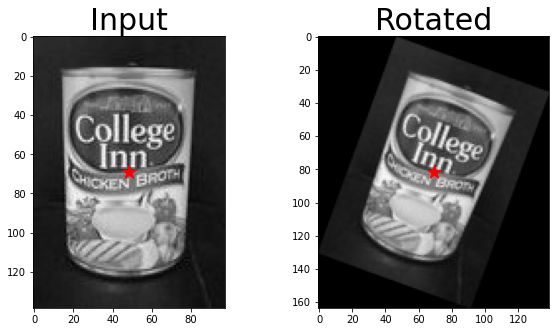

In [ ]:
# example usage of rotation function:
im = cv2.imread('data/model_can.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255
center = (np.array(im.shape[:2][::-1])-1)/2
theta = 20.0
im_rot, center_rot = rotateImage(im, theta)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")
plt.scatter(center[0], center[1], 200, 'r', '*')
plt.title("Input", fontsize=30)
plt.subplot(1,2,2)
plt.imshow(im_rot, cmap="gray")
plt.scatter(center_rot[0], center_rot[1], 200, 'r', '*')
plt.title("Rotated", fontsize=30)

* Write a test script `briefRotTest` that counts the number of correct matches of the image `model_can.jpg` as a function of rotation angle. 
    * Use the provided function `checkRotLocs` that counts the number of correctly matched points.

In [ ]:
def checkRotLocs(locs0, locsTheta, matches, theta, 
                 c0, cTheta, th_d=9.0):
    # INPUTS
    #     locs0     - m1x3 matrix of keypoints (x,y,l) of the unrotated image
    #     locsTheta - m2x3 matrix of keypoints (x,y,l) of the rotated image
    #     matches   - px2 matrix of matches indexing into locs0 and locsTheta
    #     theta     - rotation angle in degress
    #     c0        - center of the unrotated image
    #     cTheta    - center of the rotated image
    #     th_d      - threshold distance of matched keypoints in pixels
    # OUTPUTS
    #     corrMatch - number of correct matches
    # keep only the matched keypoints (x,y)
    locs0 = locs0[matches[:,0],:2]
    locsTheta = locsTheta[matches[:,1],:2]
    # rotate the locations at theta=0 and shift them to the new center
    theta = np.deg2rad(theta)
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    locs0_rot = (rot_mat@(locs0-c0).T).T+cTheta
    # count the number of correct matches with a distance threshold Td
    corrMatch = np.sum(np.sqrt(np.sum((locs0_rot-locsTheta)**2, 1)) < th_d)
    return corrMatch

This function takes as input the following: the detected keypoints `locs0` in the unrotated image ($m1 \times 3$ matrix of $(x,y,l)$), the detected keypoints `locsTheta` in the rotated image ($m2 \times 3$ matrix of $(x,y,l)$), the computed matches `matches` using the function `briefMatch` ($p \times 2$ matrix), the rotation angle `theta` in degrees, the center of the unrotated image `c0`, the center of the rotated image `cTheta`, and a distance threshld in pixels `th_d`. This threshold is used to decide whether the keypoints `locs0` after rotation and shift are matched correctly to the detected keypoints in the rotated image `locsTheta` (i.e. $|T_{\theta}(xy_0) - xy_{\theta}| < \theta_d$). (Suggested value `th_d=9.0`).

The function returns the number of correct matches `corrMatch` which is a scalar.

---

* Complete the function below, that should compute a histogram (using theta in the range(0, 360, 10)) of correct matches per rotation angle.
  
* Present the resulting historgam as a bar plot and explain why you think the descriptor behaves this way.

In [ ]:
def briefRotTest(im):
    """
    YOUR CODE HERE
    """

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>

### 2.6   Oriented Fast and Rotated BRIEF (ORB)
---

As you saw in the previous section BRIEF is not rotation-invariant. This is where ORB <a href="http://www.gwylab.com/download/ORB_2012.pdf">[4]</a> comes into play. ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance (<a href="https://docs.opencv.org/4.5.1/d1/d89/tutorial_py_orb.html">read more here</a>). 

* Repeat the previous task with the ORB descriptor using OpenCV `cv2.ORB_create()`, and compare your results with section 2.5.
* Implementaton guidance:
    * Use `orb = cv2.ORB_create()` to instantiate the ORB detector and `orb.detectAndCompute()` to detect keypoints and compute descriptors.
    * Match the detected keypoints using OpenCV brute-force matcher `cv2.BFMatcher()` (<a href="https://docs.opencv.org/4.5.1/dc/dc3/tutorial_py_matcher.html">read more here</a>).
    * Compute the number of correct matches using the function `checkRotLocs` from section 2.5. Use the provided function `openCV2numpy` to access the attributes of the "DMatch" objects returned by OpenCV matcher, and transfer them to numpy arrays. 

In [ ]:
# translate openCV to our data structs
def openCV2numpy(kp1, kp2, matches):
    # function transfers OpenCV keypoints and matches to numpy arrays
    # INPUTS
    #     kp1        - keypoints detected for img 1 using orb.detectAndCompute()
    #     kp2        - keypoints detected for img 2 using orb.detectAndCompute()
    #     matches    - matches returned by cv2.BFMatcher()
    # OUTPUTS
    #     locs1      - m1x3 matrix of keypoints (x,y,l)
    #     locs2      - m2x3 matrix of keypoints (x,y,l)
    #     matches_np - px2 matrix indexing into locs1 and locs2
    
    locs1 = np.array([[kp1[idx].pt[0],kp1[idx].pt[1], float(kp1[idx].octave)] 
                      for idx in range(0, len(kp1))]).reshape(-1, 3)
    locs2 = np.array([[kp2[idx].pt[0],kp2[idx].pt[1], float(kp2[idx].octave)] 
                      for idx in range(0, len(kp2))]).reshape(-1, 3)
    matches_np = [[mat.queryIdx, mat.trainIdx] for mat in matches]
    matches_np = np.stack(matches_np)
    return locs1, locs2, matches_np

This function takes as input the detected "Keypoint" objects: `kp1` in image 1, and `kp2` in image 2 (using `orb.detectAndCompute()`), and their "DMatch" objects `matches` (using `cv2.BFMatcher()`). The function returns the detected keypoints and matches in numpy arrays: `locs1` ($m1 \times 3$ matrix of $(x,y,l)$) for image 1, `locs2` ($m2 \times 3$ matrix of $(x,y,l)$) for image 2, and `matches_np` ($p \times 2$ matrix).

**Note**: OpenCV functions expect to recieve images in BGR format. Therefore, you may pass in images after they are transfered back into `uint8` and converted using `cv2.cvtColor(., cv2.COLOR_GRAY2BGR)`.

---


* Write a test script `orbTest` that counts the number of correct matches of the image `model_can.jpg` as a function of rotation angle using the ORB descriptor (in the same format as with the Brief detector above).
* Explain the key differences that make ORB rotation-invariant compared to BRIEF. Which components in ORB are borrowed from SIFT?
* Suggestion for debugging - You can visualize the returned list of "DMatch" objects by `cv2.BFMatcher()` using the OpenCV function `cv2.drawMatches()`. To make visual inspection easier, you can sort the matches and look only at the `K` (e.g. 10-20) strongest ones.

In [ ]:
def orbRotTest(im):
    """
    YOUR CODE HERE
    """

<span style="color: red; font-weight: bold;">YOUR EXPLANATION HERE</span>


# Part 3 - Planar Homographies and Image Stitching
---
After we saw how descriptors are implemented and performed, now we will see how to use them for homographis.

In this part you will implement an image stitching algorithm, and will learn how to stitch several images of the same scene into a panorama. First, we’ll concentrate on the case of two images and then extend to several images.

### Planar Homographies: Theory review
---
Suppose we have two cameras $C_1$ and $C_2$ looking at a common plane $Π$ in 3D space. Any 3D point $P$ on $Π$ generates a projected 2D point located at $p ≡ (x,y,1)^T$ on the ﬁrst camera $C_1$ and $q ≡ (u,v,1)^T$ on the second camera $C_2$. Since $P$ is conﬁned to the plane $Π$, we expect that there is a relationship between $p$ and $q$. In particular, there exists a common $3 × 3$ matrix $H$, so that for any $P$, the following conditions holds: 
\begin{align}
\text{(1) }q ≡ Hp
\end{align}



We call this relationship *'planar homography'*. Recall that both $p$ and $q$ are in homogeneous coordinates and the equality $≡$ means $p$ is proportional to $Hq$ (recall homogeneous coordinates). It turns out this relationship is also true for cameras that are related by pure rotation without the planar constraint. 

#### **Matched points:**
---

Given a set of points $p = \{p_1,p_2,...,p_N\}$ in an image taken by camera $C_1$ and corresponding points $q = \{q_1,q_2,...,q_N\}$ in an image taken by $C_2$. Suppose we know there exists an unknown homography $H$ between corresponding points for all $i ∈\{1,2,...,N\}$. This formally means that $\exists H$ such that: 

 
\begin{equation*} 
\text{(2) } q^i ≡ Hp^i
\end{equation*}


where $p^i = (x_i,y_i,1)$ and $q^i = (u_i,v_i,1)$ are homogeneous coordinates of image points each from an image taken with $C_1$ and $C_2$ respectively.

* Given $N$ correspondences in $p$ and $q$ and using Equation 2, we derived a set of $2N$ independent linear equations in the form:


\begin{equation*} 
\text{(3) } Ah = 0
\end{equation*}


where $h$ is a vector of the elements of $H$ and $A$ is a matrix composed of elements derived from the point coordinates:  

$$ \begin{bmatrix} &&&&&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 & -x_iu_i&-y_iu_i& -u_i \\ 0&0&0&x_i&y_i&1 & -x_iv_i&-y_iv_i& -v_i \\ &&&&&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ h_7\\h_8\\h_9\\ \end{bmatrix} = \begin{bmatrix} \dots \\ 0 \\ 0  \\ \dots \end{bmatrix}$$


Each point pair contributes 2 equations and therefore we need at least 4 matches.

### 3.1 SIFT Matching
---

* Implement the following SIFT matching function, that returns a list of putative matches (according to the criterions learned in class).
You may use here the OpenCV [2]  SIFT implementation for detection and description, but you should implement yourselves the matching stage, returning the (up to `k_matches`) leading matches according to the 'ratio-test' score studied in class.

In [ ]:
# Loading packages
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline

In [ ]:
def SIFT_matches(img1, img2, k_matches=50):
    '''
    performs the descriptor matching
    inputs  : img1 and img2 - two images loaded by cv2.imread
              k_matches - maximal number of matches to be returned
    outputs : p1 and p2 are matrices, each 2xN (where N<=k) holding the (x,y) coordinates of the N putative matched keypoints
    '''
    """
    YOUR CODE HERE
    """
    return p1, p2

* The following visualization function enbales observing match correspondences

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_matches(img1, img2, p1, p2):
    # Convert images to RGB if they're grayscale
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    # Stack images horizontally
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    height = max(h1, h2)
    vis = np.zeros((height, w1 + w2, 3), dtype=np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1 + w2] = img2

    # Shift p2 x-coordinates to match img2's position in vis
    p2_shifted = p2.copy()
    p2_shifted[:, 0] += w1

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(vis)
    for i in range(p1.shape[0]):
        pt1 = p1[i]
        pt2 = p2_shifted[i]
        color = np.random.rand(3,)  # Random color for each match
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color=color, linewidth=1)
        plt.scatter([pt1[0], pt2[0]], [pt1[1], pt2[1]], color=color, s=8, edgecolors='black')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


* Use the above fuction to show correspondences for both pairs of images

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Loading images
img1_can = cv2.imread('./data/model_can.jpg')
img2_can = cv2.imread('./data/can_03.jpg')
img1_incline = cv2.imread('./data/incline_L.png')
img2_incline = cv2.imread('./data/incline_R.png')
"""
YOUR CODE HERE
"""

### 3.2 Homography Estimation 
---

Implement a function that gets a set of matching points between two images and calculates the transformation between them. The transformation should be $3\times3$ $H$ homogenous matrix such that for each point in image $p\in C_1$, there would be a transformation in image $C_2$ such that $p=Hq$, $q\in C_2$.
* Implement the following function, with explanation comments in your implementation.
* Remember that a homography is only determined up to scale. The `numpy`'s functions `eig()` or `svd()` will be useful. Note that this function can be written without an explicit for-loop over the data points.

*Hint for debugging*: A good test of your code is to check that the homography of an image with itself is an identity.

In [ ]:
def computeH(p1, p2):
    '''
    Inputs: `p1` and `p2` should be 2 x N matrices of corresponding 
            (x,y)^T coordinates between two images. 
    Outputs: `H2to1` should be a 3 x 3 matrix encoding the homography
            that best matches the linear equation derived above for Equation 2. 
    '''
    """
    YOUR CODE HERE
    """
    return H2to1

* Show that the transformation is correct by selecting arbitrary points in the second image and projecting them to the first image, by completing and running the following script:

In [ ]:
# Computing the homography transformation using the matched SIFT keypoints
p1, p2 = SIFT_matches(img1, img2, k_matches = 10)
H2to1 = computeH(p1, p2)

# Arbitrarily choosing points to demonstrate projection
img2_pts = np.array([[138, 70, 1], [100, 63, 1], [145, 116, 1]]) # Adding the third coordinate to be a fixed 1 for homogenuous coordinates

# Computing the first image's projected points coordinates
img1_pts = """ YOUR CODE HERE """

# Plotting
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.plot(img1_pts[:, 0], img1_pts[:, 1], 'ro')
_ = plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.plot(img2_pts[:, 0], img2_pts[:, 1], 'ro')
_ = plt.axis('off')
plt.show()

### 3.3 Alignment of a Pair of Images
---
Next is given a function that gets two images and an H2to1 homography between them (as above). It warps the second image and returns its union with img1, contained in the minimal containing rectangle.

In [ ]:
import numpy as np
import cv2

def merge_images_min_canvas(img1, img2, H2to1):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Step 1: Define image corner points
    corners_img1 = np.array([[0, 0],[w1, 0],[w1, h1],[0, h1]], 
                            dtype=np.float32).reshape(-1, 1, 2)

    corners_img2 = np.array([[0, 0],[w2, 0],[w2, h2],[0, h2]], 
                            dtype=np.float32).reshape(-1, 1, 2)

    # Step 2: Warp corners of img2 into img1 space
    warped_corners_img2 = cv2.perspectiveTransform(corners_img2, H2to1)

    # Step 3: Stack all corners
    all_corners = np.vstack([corners_img1, warped_corners_img2]).reshape(-1, 2)

    # Step 4: Find bounding box
    x_min, y_min = np.floor(all_corners.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(all_corners.max(axis=0)).astype(int)
    out_width = x_max - x_min
    out_height = y_max - y_min

    # Step 5: Compute translation homography to shift everything into +ve space
    translation = np.array([[1, 0, -x_min],[0, 1, -y_min],[0, 0, 1]], 
                           dtype=np.float32)

    # Step 6: Warp img2 using adjusted homography
    H2to1_translated = translation @ H2to1
    img2_warped = cv2.warpPerspective(img2, H2to1_translated, (out_width, out_height))

    # Step 7: Paste img1 into the output canvas
    merged = img2_warped.copy()
    # Create a mask for non-zero pixels in img1
    mask1 = (img1 > 0).any(axis=2)
    y_offset, x_offset = -y_min, -x_min
    merged[y_offset:y_offset+h1, x_offset:x_offset+w1][mask1] = img1[mask1]

    return merged, translation


* Use the above functions to create a stitched panorama image from the two can images. Complete the missing code:

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Demonstrating image alignment of a pair of can images
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Loading two can images and 
# computing SIFT keypoints and descriptors
img1 = cv2.imread('../data/model_can.jpg')
img1 = img1[:,:50,:] # use left crop of this image
img2 = cv2.imread('../data/can_03.jpg')

# Computing k ched SIFT keypoints
p1, p2 = '''YOUR CODE HERE'''

# Plotting matches
show_matches(img1, img2, p1.T, p2.T)

# Computing the homography matrix
H2to1 = '''YOUR CODE HERE'''

# # Creating the warped right image using cv2.warpPerspective
# img2_warped = '''YOUR CODE HERE'''

# Merge together to form the complete panorama
panoImg, _ = merge_images_min_canvas(img1, img2, H2to1)

# Plotting panorama
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(panoImg, cv2.COLOR_BGR2RGB))
plt.title('Panorama')
plt.axis('off')
plt.show()

### 3.4 Stitching of Sequence of Images:
---
* Implement your own stitching pipeline, **based on the above functions**, where the sequence should be stitched by leaving (one of) the middle frame(s) in tact and warping the other images towards it, as in the example shown in class:

![Diagram](./examples/seq_balcony.png)
![Diagram](./examples/panorama_balcony.jpg)

* Background can be either white or black and the containing rectangle should be minimal

* Show stitching results on two different sequences:
    * The `./data/sintra` sequence.
    * A sequence of your own, that contains at least 5 images.

* For each sequence, show stitching results, where matching of image pairs is done using (the top) k matches, for k = 4, 10 and 100
    * Make sure to include the used k in the caption of your figure

* Discuss the quality of the results

In [ ]:
"""
YOUR CODE HERE
"""

<span style="color: red; font-weight: bold;">YOUR DISCUSSION HERE</span>

### 3.5 Stitching with RANSAC:
* Complete the following partial implementation of the RANSAC (**Ran**dom **Sa**mple **C**onsensus) algorithm for Homography estimation.

In [ ]:
def ransacH(p1, p2, nIter=..., tol=...):
    N = p1.shape[1]
    stacked_p2 = np.vstack((p2, np.ones(N)))

    best_inliers_n = 0
    best_inliers = []

    # MAIN LOOP
    for iter in range(nIter):
        """
        YOUR CODE HERE
        """
        
    # final homograpy, based on detected set of inliers
    bestH = computeH(best_inliers[0], best_inliers[1])
    return bestH

In [ ]:
* Repeat the stitching of the two sequences from 3.4, however, this time use k=200 sift matches and use RANSAC
* Discuss your results in comparison with those above

In [ ]:
"""
YOUR CODE HERE
"""

<span style="color: red; font-weight: bold;">YOUR DISCUSSION HERE</span>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> References & Credits
* [1] P. Burt and E. Adelson. The Laplacian Pyramid as a Compact Image Code. IEEE
Transactions on Communications, 31(4):532{540, April 1983.
* [2] David G. Lowe. Distinctive Image Features from Scale-Invariant Keypoints. Inter-
national Journal of Computer Vision, 60(2):91{110, November 2004.
* [3] Michael Calonder, Vincent Lepetit, Christoph Strecha, and Pascal Fua. BRIEF: Binary Robust Independent Elementary Features.
* [4] Rublee, Ethan, Vincent Rabaud, Kurt Konolige, and Gary Bradski. "ORB: An efficient alternative to SIFT or SURF."
* Carnegie Mellon University - CMU
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
